# This notebook covers the following topics: 

- Improving the read-in data time.
- Improving computational performance for both baseline model and alternative model.
- Interpretaion/Summary.

### Reiterate our incentives: 

By building a model to improve the Zestimate residual error, we will help millions of American household make accurate estimation on their home value. The resulting model will better the current Zestimate system and help the company with targeting their ads and service, boosting the overal revenue. 

Also, starting 2019, Zillow had started buying and selling homes as an agency. Thus, it is more and more important for them to know the value of their purchases and the profit these properties will generate in the market. and our model will help them make better purchase decisions. 

Since both the estimation price and the actual selling price are confidential, our most important feature is provided by the Zillow dataset, which is the log-error between their Estimate price and the actual sale price. It is defined as: logerror=log(Zestimate)−log(SalePrice)

## 1, Load libraries and import data

In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

import dask.dataframe as dd
import inspect
import os
import requests

%matplotlib inline

CPU times: user 1.34 s, sys: 411 ms, total: 1.75 s
Wall time: 2.5 s


In [5]:
%%time
train = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'])
train.shape

CPU times: user 43.7 ms, sys: 7.78 ms, total: 51.5 ms
Wall time: 54.4 ms


(90275, 3)

In [2]:
%%time
#dask version read in data
train_dask = dd.read_csv('train_2016_v2.csv', 
                        encoding = 'latin-1',
                        assume_missing=True)

CPU times: user 17.5 ms, sys: 4.55 ms, total: 22.1 ms
Wall time: 604 ms


In [28]:
%%time
prop = pd.read_csv('properties_2016.csv')
prop.shape

CPU times: user 12.1 s, sys: 4.19 s, total: 16.3 s
Wall time: 21.8 s


(2985217, 58)

In [29]:
%%time
#dask version read in data
prop_dask = dd.read_csv('properties_2016.csv', 
                        encoding = 'latin-1',
                        assume_missing=True)

CPU times: user 59.6 ms, sys: 36 ms, total: 95.7 ms
Wall time: 96.6 ms


## By comparing the time of execution, we can conclude that dask improved data read-in speed significantly

In [30]:
%%time
prop.head()

CPU times: user 394 µs, sys: 19 µs, total: 413 µs
Wall time: 410 µs


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


## 2, Deciding on the feature variables

In [31]:
%%time
prop.columns

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

CPU times: user 47.8 ms, sys: 9.62 ms, total: 57.5 ms
Wall time: 69.7 ms


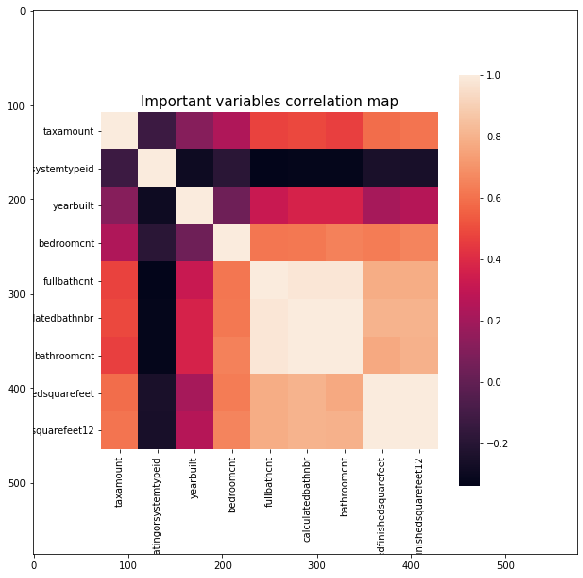

In [32]:
%%time
img = mpimg.imread('figure.png')
plt.figure(figsize=(10,10))
plt.imshow(img)

### According to this heating map from HW2, I've decided to use 'taxamount', 'yearbuilt', 'bedroomcnt', 'bathroomcnt', 'heatingorsystemtypeid', 'calculatedfinishedsquarefeet' as key features, and drop the rest of the columns. 

In [33]:
%%time
X = prop[['parcelid', 'taxamount','yearbuilt','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
X.head()

CPU times: user 71.4 ms, sys: 125 ms, total: 196 ms
Wall time: 203 ms


,parcelid,taxamount,yearbuilt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
0,10754147,NaN,NaN,0.0,0.0,NaN
1,10759547,NaN,NaN,0.0,0.0,NaN
2,10843547,20800.37,NaN,0.0,0.0,73026.0
3,10859147,14557.57,1948.0,0.0,0.0,5068.0
4,10879947,5725.17,1947.0,0.0,0.0,1776.0


## 3, Remove NaNs/0s and merge X with train

In [34]:
%%time
X = X.dropna()
X = X[(X.bathroomcnt > 0) & (X.bedroomcnt > 0) & (X.calculatedfinishedsquarefeet > 0)]
X.shape

CPU times: user 288 ms, sys: 160 ms, total: 448 ms
Wall time: 453 ms


(2843162, 6)

In [35]:
%%time
X.head()

CPU times: user 324 µs, sys: 16 µs, total: 340 µs
Wall time: 329 µs


,parcelid,taxamount,yearbuilt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet
19,11324547,6941.39,2005.0,2.0,4.0,3633.0
26,11488147,10455.41,1972.0,4.0,5.0,2865.0
28,11524947,6165.36,2004.0,2.0,2.0,1090.0
29,11544747,10244.94,2011.0,4.0,3.0,1620.0
31,11585547,7924.68,1926.0,2.0,3.0,2077.0


In [36]:
%%time
X = pd.merge(X, train, on='parcelid')#Merge X and train
X.shape

CPU times: user 600 ms, sys: 239 ms, total: 839 ms
Wall time: 871 ms


(88735, 8)

## 4, Sorting

In [37]:
%%time
X.sort_values(by=['parcelid', 'transactiondate'], inplace=True)
X.head()

CPU times: user 49.8 ms, sys: 27.7 ms, total: 77.5 ms
Wall time: 78.4 ms


,parcelid,taxamount,yearbuilt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,logerror,transactiondate
61013,10711738,7219.18,1978.0,3.0,4.0,2538.0,0.0276,2016-08-02
81581,10711755,6901.09,1959.0,3.0,3.0,1589.0,-0.0182,2016-08-02
4319,10711805,4876.61,1973.0,2.0,3.0,2411.0,-0.1009,2016-05-03
12360,10711816,5560.07,1973.0,2.0,4.0,2232.0,-0.0121,2016-04-05
82881,10711858,4878.25,1973.0,2.0,4.0,1882.0,-0.0481,2016-07-15


## 5, Adding new feature transaction_yearmonth(2016) to our df for computing distance measurement.

In [38]:
%%time
X['transaction_yearmonth'] = 100 * X['transactiondate'].dt.year + X['transactiondate'].dt.month
X.head()

CPU times: user 12.1 ms, sys: 1.41 ms, total: 13.5 ms
Wall time: 12.9 ms


,parcelid,taxamount,yearbuilt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,logerror,transactiondate,transaction_yearmonth
61013,10711738,7219.18,1978.0,3.0,4.0,2538.0,0.0276,2016-08-02,201608
81581,10711755,6901.09,1959.0,3.0,3.0,1589.0,-0.0182,2016-08-02,201608
4319,10711805,4876.61,1973.0,2.0,3.0,2411.0,-0.1009,2016-05-03,201605
12360,10711816,5560.07,1973.0,2.0,4.0,2232.0,-0.0121,2016-04-05,201604
82881,10711858,4878.25,1973.0,2.0,4.0,1882.0,-0.0481,2016-07-15,201607


In [39]:
%%time
min_transaction_yearmonth = X.transaction_yearmonth.min()
X['transaction_yearmonth_i'] = X.transaction_yearmonth - min_transaction_yearmonth
np.sort(X.transaction_yearmonth_i.unique())

CPU times: user 3.01 ms, sys: 1.2 ms, total: 4.21 ms
Wall time: 2.84 ms


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

## 6, Estimate a baseline model(KNN)

In [40]:
%%time
y = X.logerror
X = X[['bathroomcnt', 'bedroomcnt', 'taxamount', 'yearbuilt', 'calculatedfinishedsquarefeet', 'transaction_yearmonth_i']]
print ("X shape =", X.shape)
print ("y shape =", y.shape)
X.head()

X shape = (88735, 6)
y shape = (88735,)
CPU times: user 7.07 ms, sys: 4.93 ms, total: 12 ms
Wall time: 11.2 ms


,bathroomcnt,bedroomcnt,taxamount,yearbuilt,calculatedfinishedsquarefeet,transaction_yearmonth_i
61013,3.0,4.0,7219.18,1978.0,2538.0,7
81581,3.0,3.0,6901.09,1959.0,1589.0,7
4319,2.0,3.0,4876.61,1973.0,2411.0,4
12360,2.0,4.0,5560.07,1973.0,2232.0,3
82881,2.0,4.0,4878.25,1973.0,1882.0,6


## Fit nearest neighbors regression

CPU times: user 2min 47s, sys: 8.16 s, total: 2min 55s
Wall time: 2min 56s


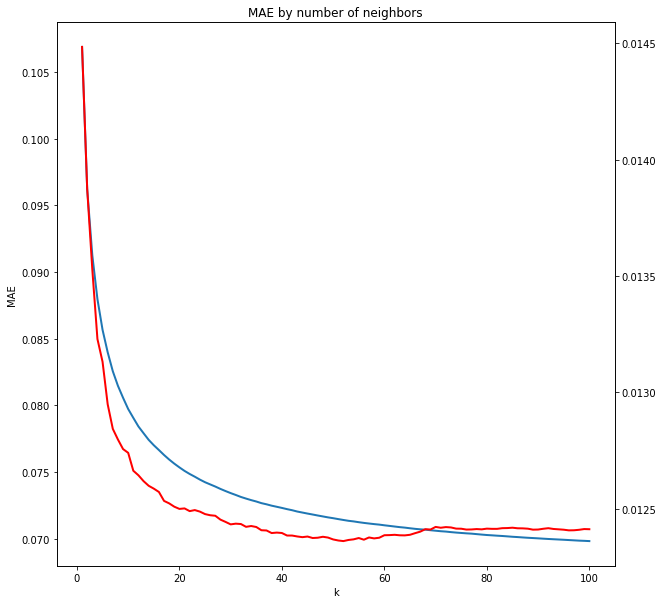

In [41]:
%%time
n_neighbors_lst = np.arange(1, 100+1, 1)#setting number of neighbors
mae_lst = []
std_lst = []

#for loop to iterate the increment of number of neighbors.
for n_neighbors in n_neighbors_lst: 
    #n_neighbors = 5
    weights = 'distance'
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
#Attributes to cross_val_score:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
    scores = cross_val_score(knn, X, y, scoring='neg_mean_absolute_error', cv=5)
    scores = np.fabs(scores)#getting the absolute value
    mean_score = np.mean(scores)#getting the mean of score
    std_score = np.std(scores)#getting the std of score
    
    mae_lst.append(mean_score)
    std_lst.append(std_score)

plt.figure(figsize=(10,10))
plt.plot(n_neighbors_lst, mae_lst, linewidth=2)
plt.title('MAE by number of neighbors')
plt.xlabel('k')
plt.ylabel('MAE')

plt2 = plt.twinx()
plt2.plot(n_neighbors_lst, std_lst, linewidth=2, color='red')

## Before changing n_jobs, the above calculation takes up to 2min 56s.

CPU times: user 3.17 s, sys: 2.14 s, total: 5.31 s
Wall time: 1min 14s


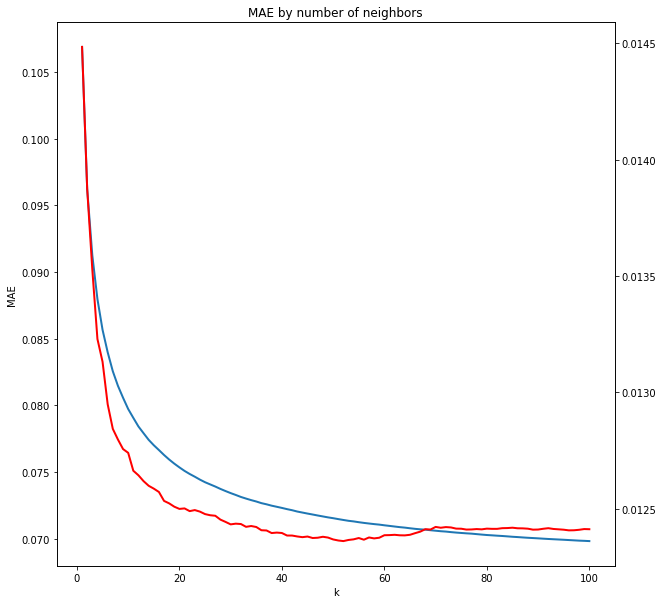

In [42]:
%%time
n_neighbors_lst = np.arange(1, 100+1, 1)
mae_lst = []
std_lst = []

for n_neighbors in n_neighbors_lst: 
    #n_neighbors = 5
    weights = 'distance'
    #adding n_jobs=4 to knn
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights, p=2, 
                                        metric='minkowski', n_jobs=4)
    #adding n_jobs=4 to cross_val_score
    scores = cross_val_score(knn, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=4)
    scores = np.fabs(scores)
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    mae_lst.append(mean_score)
    std_lst.append(std_score)

plt.figure(figsize=(10,10))
plt.plot(n_neighbors_lst, mae_lst, linewidth=2)
plt.title('MAE by number of neighbors')
plt.xlabel('k')
plt.ylabel('MAE')

plt2 = plt.twinx()
plt2.plot(n_neighbors_lst, std_lst, linewidth=2, color='red')

## After setting n_jobs=4 to both cross_val_score and neighbors.KNeighborsRegressor, the time it takes to execute was halved to 1min 14s.

In [43]:
inspect.signature(cross_val_score)

<Signature (estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)>

In [44]:
inspect.signature(neighbors.KNeighborsRegressor)

<Signature (n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)>

## 7, Fit another model(i.e. RandomForestRegressor) and compare

In [46]:
%%time
#Attributes for n_jobs=-1
#https://datascience.stackexchange.com/questions/34416/scikit-learn-n-jobs-parameter-on-cpu-usage-memory
parameters = {'n_estimators':[50,75,100],'n_jobs':[-1],'oob_score':[False]}
model = RandomForestRegressor()
#Attributes to GridSearchCV
#https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)  
grid.fit(X,y)

CPU times: user 1min 35s, sys: 13.5 s, total: 1min 48s
Wall time: 1min 11s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

## Originally, this operation's wall time takes up to 1min 11s, cpu time takes up to 1min 48s.

In [49]:
%%time
parameters = {'n_estimators':[50,75,100],'n_jobs':[-1],'oob_score':[False]}
model = RandomForestRegressor()
#adding n_jobs = 4 to gridsearchcv
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error', n_jobs = 4, cv=3)  
grid.fit(X,y)

CPU times: user 1min 15s, sys: 1.2 s, total: 1min 17s
Wall time: 1min


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

## Now with n_jobs = 4, wall time is reduced to 1min, and cpu time is reduced to 1min 17s.

## Evaluate

  param_n_estimators  mean_test_score  std_test_score
0                 50        -0.077612        0.010629
1                 75        -0.076828        0.010575
2                100        -0.076427        0.010631
CPU times: user 354 ms, sys: 262 ms, total: 617 ms
Wall time: 422 ms


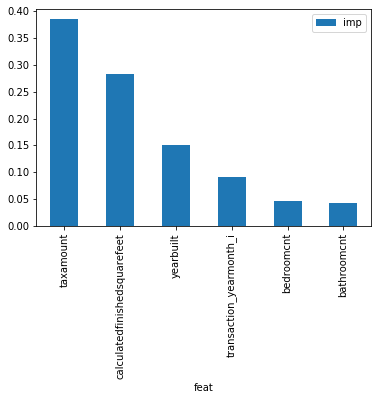

In [47]:
%%time
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results[["param_n_estimators","mean_test_score","std_test_score"]])

feat_imps = grid.best_estimator_.feature_importances_
fi = pd.DataFrame.from_dict({'feat':X.columns,'imp':feat_imps})
fi.set_index('feat',inplace=True,drop=True)
fi = fi.sort_values('imp',ascending=False)
fi.plot.bar()

In [48]:
%%time
grid.score(X,y)

CPU times: user 4.23 s, sys: 52.2 ms, total: 4.28 s
Wall time: 728 ms


-0.028362101322583547

## Summary

In this HW, I first applied %%time to every code block in order to find the bottlenecks. Then I applied both dask and n_jobs to speed up the computation. Since I have relatively big datasets, dask improved my data read-in speed significantly. CPU total dropped from 16.3s to 95.7ms, and wall time dropped from 21.8s to 96.6ms.

As for n_jobs, I changed it to n_jobs=4 for both KNN and RF regressor, and the execution time for KNN was more than halved(i.e. wall time dropped from 2min 55s to 1min 14s), however, the RF's execution time was only reduced 11s(i.e. wall time dropped from 1min 11s to 1min).  

I also tried changing n_jobs to numbers bigger than 4, but the performance was not improved as expected. After reading post https://datascience.stackexchange.com/questions/34416/scikit-learn-n-jobs-parameter-on-cpu-usage-memory, I noticed the meaning of changing n_jobs to -1, and applied this to GridSearchCV, but did not see much of an improvement.